## PCA in Python
In notebook we explore an attempt to reduce the dimensionality of segment_timbre data within the mss_df using PCA.

Implementing PCA in Python Step by Step: http://sebastianraschka.com/Articles/2014_pca_step_by_step.html



In [1]:
import os
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py 
import os
import itertools
import re
from sklearn.preprocessing import scale
%matplotlib inline

<b>Load the files we need</b><br>
* <b>mss_df</b>: Contains the DF we've been using all semester
* <b>timbre_master</b>: Contains the timbre data for the 12 columns of every song.


In [2]:
save_load_path = '/Users/mikebrennan/Dropbox/Bentley/MA755'
mss_df = pd.read_pickle(save_load_path+'/assignment1.pkl')
timbre_master = pd.read_pickle(save_load_path+'/timbre_master.pkl')

<b>Helper functions provided by Professor Oury</b><br>

In [3]:
def get_filenames(path):
    return([get_filenames(path+"/"+entry.name)
            if entry.is_dir() 
            else path+"/"+entry.name 
            for entry 
            in os.scandir(path)
           ])
def unlist(alist):
    return(list(itertools.chain.from_iterable(alist)
               )
          )
def check_HDF5_Group(Group):
    for key in list(Group.keys()):
        print('key:', key)
    for value in list(Group.values()):
        print('value:', value)

def check_HDF5_Dataset(Dataset):
    print('shape:',Dataset.shape)
    print('dtype:',Dataset.dtype)
    print('type(bc.value):',type(Dataset.value))
    print('value:',Dataset.value)
    
    
path = "/Users/mikebrennan/desktop/MillionSongSubset/data"
x = unlist(unlist(unlist(get_filenames(path))))
p = re.compile("\.h5$")
y = [filename for filename in x if p.search(filename)]


### Helper functions for the PCF Process
* <b>get_timbre(file)</b>: Returns back the N x 12 segment_timbre matrix for a given file.
* <b>pcf(matrix)</b>: Ingests a Timbre matrix and returns the Eigen Values and Eigen Vectors for that matrix.
* <b>extract_eign(pair)</b>: Takes in an eigen value / eigen vector pair and returns only the eigen values
* <b>var_explained(eig,i)</b>: Injest an array of eigen values.  Returns how much variability in the data is explained by using the first i-th principle comonents within.  

### get_timbre(file)


In [55]:
#This gets the timbre data for any given file.
def get_timbre(file):
    store=pd.HDFStore(y[file],auto_close=True)
    m=(np.matrix(store.root.analysis.segments_timbre.read()))
    store.close()
    return(m)

def get_pitch(file):
    store=pd.HDFStore(y[file],auto_close=True)
    m=(np.matrix(store.root.analysis.segments_pitches.read()))
    store.close()
    return(m)

This shows that the Timbre Data for file 1 is a 550 row / 12 column array.

In [56]:
T = get_pitch(765)
T.shape

(489, 12)

In [60]:
T

matrix([[ 0.841,  0.886,  0.902, ...,  1.   ,  0.879,  0.706],
        [ 0.896,  1.   ,  0.727, ...,  0.513,  0.48 ,  0.072],
        [ 0.781,  0.619,  0.493, ...,  0.596,  1.   ,  0.132],
        ..., 
        [ 0.742,  0.191,  0.818, ...,  1.   ,  0.943,  0.224],
        [ 0.242,  0.074,  0.463, ...,  0.224,  0.155,  0.028],
        [ 0.18 ,  0.185,  0.109, ...,  0.178,  1.   ,  0.205]])

### pcf(matrix)

In [7]:
##THIS FUNCTION RETURNS A SERIES OF EIGN VALUES AND EIGN VECTORS
def pcf(matrix):
    #scale the data
    A_s = scale(matrix, with_mean=True,with_std=True,axis=0)
    #covariance matrix
    A_c = np.cov(A_s.T)
    #Get the eign values and eign vectors
    eig_val_cov, eig_vec_cov = np.linalg.eig(A_c)
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i])
             for i in range(len(eig_val_cov))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort
    eig_pairs.reverse
    return(eig_pairs)

<b>This shows the first Eigen value of Matrix T is 2.045</b>

In [8]:
E=pcf(T)
print("Eigen Value + Vector 1")
print(E[0]) 
print(" ")
print("Eigen Value + Vector 2")
print(E[1])

Eigen Value + Vector 1
(2.0450203409914343, array([-0.14167896, -0.41143944, -0.41716542,  0.45016564, -0.1971815 ,
       -0.16398986, -0.13400152, -0.41555515,  0.27500877,  0.11732501,
       -0.25323009,  0.15502385]))
 
Eigen Value + Vector 2
(1.5975562864674302, array([ 0.14429293, -0.38439766,  0.22363811, -0.31158759, -0.03192046,
        0.36095346,  0.58735361, -0.25426128,  0.33284296,  0.16460346,
       -0.06503526, -0.03562943]))


### extract_eign(pair)

Takes in an eigen value / eigen vector pair and returns only the eigen values

In [9]:
#This function extracts the eign value out of the eign value / vector pair
def extract_eign(pair):
    eig_val=[0]*len(pair)
    index=0
    for i in pair:
        eig_val[index]=i[0]
        index+=1
    return(eig_val)

In [10]:
eign = extract_eign(E)
print(eign)

[2.0450203409914343, 1.5975562864674302, 1.5729351601104455, 1.1538888600974651, 1.0840458128591217, 1.0221599143756928, 0.82829307707958866, 0.53594939854509749, 0.44829103351466798, 0.6253070276069117, 0.36759278823371555, 0.74081822361568972]


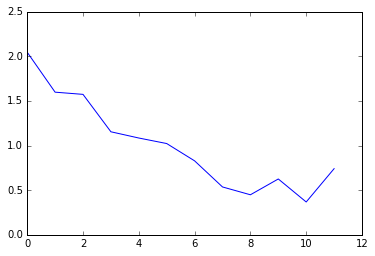

In [11]:
plt.plot(eign)

### var_explained

In [12]:
def var_explained(eig,i):
    cum_per=0
    per_var=0
    for e_val in (eig[0:i]):
        per_var = round((e_val / len(eig)),3)
        cum_per+=per_var
    return(cum_per)


In [13]:
var_explained(eign,5)

0.62

## Reducing Segment_timbre data.

Goal: Segments_timbre contains 12 columns of data and N rows for every song.  Can we reduce those N-rows into a much smaller number of components?

### What does the data look like:

First, the vast majorty songs have greater than 100 measurements of Timbre

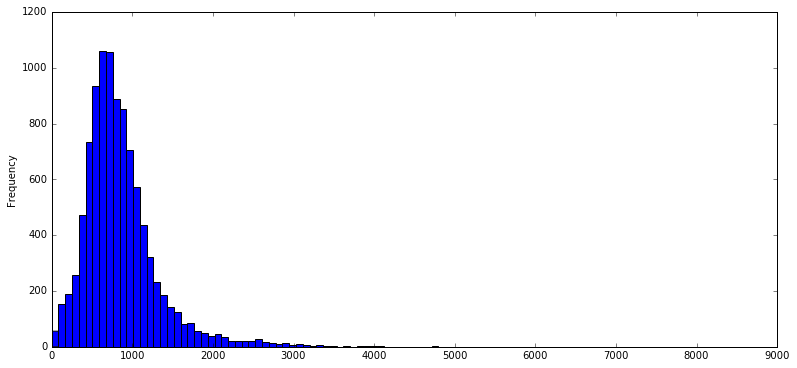

In [14]:
fig = plt.figure(1, figsize=(13,6))
mss_df['timbre_size'].plot(kind='hist',bins=100)

### Timbre_master

* Contains 100 dimensions of data.
* Each dimension represents the nth Timbre Measurement.
* Each row represents a song and a Timbre Column.

For example: In the data below, row one represents the following:
* The first 100 measurements of the first column (column A) of the timbre matrix for song 0


In [15]:
timbre_master.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,song,t_column
0,0.000,19.991,20.597,20.908,22.173,32.381,29.165,30.153,31.814,33.914,...,45.346,38.965,43.164,41.174,45.831,46.334,40.192,43.187,0,A
0,0.000,35.141,42.317,37.802,39.138,37.612,42.706,38.668,36.981,37.551,...,44.266,42.740,42.895,45.724,48.951,45.939,42.161,42.601,1,A
0,0.000,23.090,48.838,49.084,48.292,48.906,49.099,49.792,47.931,48.581,...,50.067,49.053,46.997,50.436,48.947,48.499,47.468,46.425,2,A
0,24.937,43.154,46.638,48.717,48.772,45.262,46.314,48.768,47.163,45.691,...,45.992,48.819,49.263,47.921,45.024,42.557,43.343,42.500,3,A
0,0.089,24.613,39.451,48.395,46.541,41.166,49.721,45.579,44.085,40.260,...,39.488,45.068,45.983,46.448,43.384,47.344,45.702,45.459,4,A


### Lets look at Song 0.  

In [16]:
mss_df.iloc[0]['title']

b"I Didn't Mean To"

In [17]:
timbre_master[timbre_master['song']==0]

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,song,t_column
0,0.000,19.991,20.597,20.908,22.173,32.381,29.165,30.153,31.814,33.914,...,45.346,38.965,43.164,41.174,45.831,46.334,40.192,43.187,0,A
0,171.130,-143.504,-203.829,-201.426,-213.799,-78.360,-67.640,-80.111,27.551,-24.665,...,8.796,-79.442,65.287,-2.465,-21.435,29.093,114.053,125.550,0,B
0,9.469,-118.249,-159.915,-151.280,-150.301,-53.789,-155.610,-36.208,-88.127,-30.398,...,21.656,18.090,2.219,-12.431,32.927,40.496,-16.892,-100.649,0,C
0,-28.480,-142.909,-89.765,-97.035,-58.292,-164.287,127.617,-116.771,-45.239,-1.917,...,46.240,-18.243,-1.940,-78.902,-38.521,47.446,-38.395,-46.674,0,D
0,57.491,-18.528,29.646,21.393,16.520,-33.002,-24.482,-71.039,-64.825,-112.764,...,11.685,-29.635,-26.822,-61.084,-13.275,-32.983,-32.349,-31.545,0,E
0,-50.067,-4.209,-45.432,-58.436,-48.170,72.774,-30.637,108.115,4.422,4.378,...,-2.250,17.555,13.478,40.959,7.517,14.035,42.068,-8.968,0,F
0,14.833,29.338,15.733,23.213,27.457,43.587,20.712,44.365,20.087,4.076,...,51.123,50.537,60.019,44.754,37.826,0.543,4.136,2.492,0,G
0,5.359,-6.477,29.094,2.776,42.717,30.991,-11.938,-15.484,-82.550,24.822,...,-38.643,7.398,-53.866,18.103,11.747,40.834,-29.717,12.638,0,H
0,-27.228,-27.491,-6.805,-1.912,-13.197,25.142,-18.121,-11.911,-22.210,-17.434,...,22.721,-3.905,3.154,15.368,53.359,17.342,38.602,38.944,0,I
0,0.973,38.106,9.460,7.690,3.489,-34.629,-20.070,6.424,32.330,-12.773,...,37.726,32.325,13.802,33.531,31.497,-2.497,5.860,15.985,0,J


### What does Timbre Look Like?

The plots below show the first 100 measurements of the Timbre Data for song 0.
Timbre values appear to be correlated over time.  That correlation can be exploited for PCA

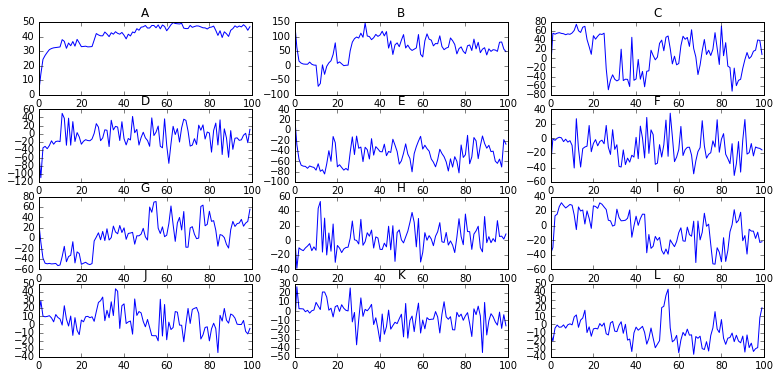

In [18]:
fig = plt.figure(1, figsize=(13,6))
for i in np.arange(12):
    plt.subplot(4,3,i+1)
    plt.plot(timbre_master[timbre_master['song']==10].iloc[i][0:100])
    plt.title(str(timbre_master[timbre_master['song']==10].iloc[i]['t_column']))
#plt.figure(131)
#plt.subplot(3,3,3)
#plt.plot(timbre_master[timbre_master['song']==0].iloc[11][0:100])
#plt.plot(timbre_master[timbre_master['song']==1].iloc[11][0:100])
#plt.plot(timbre_master[timbre_master['song']==2].iloc[11][0:100])


## PCA: Timbre Column A

In [19]:
#Step 1. Get the Timbre Measurements 
column_a = timbre_master[timbre_master['t_column']=='A']

#Step 2.  Conver the first 100 columns into a matrix
mat=np.matrix(column_a.ix[:,0:100])

#Step 3.  Get the Eign values and associated Eign Vectors
Eig_a=pcf(mat)


<b>We can see in the plot below that the Eigen Values cut out very quickly after the first 2 values.</b>

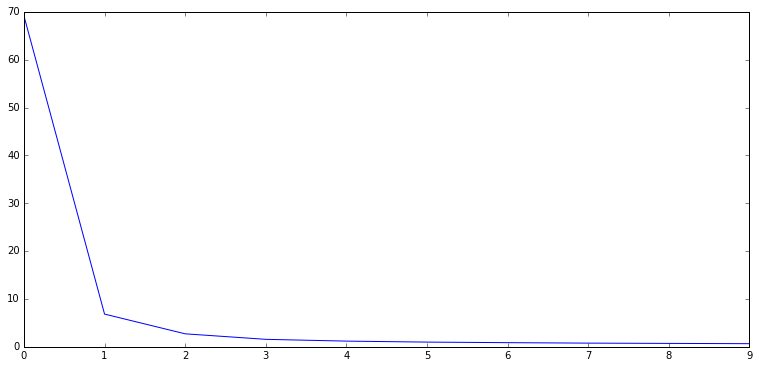

In [20]:
#Extract the Eign values
eig_val_a= extract_eign(Eig_a)
fig = plt.figure(1, figsize=(13,6))
plt.plot(eig_val_a[0:10])

(0.5, 1)

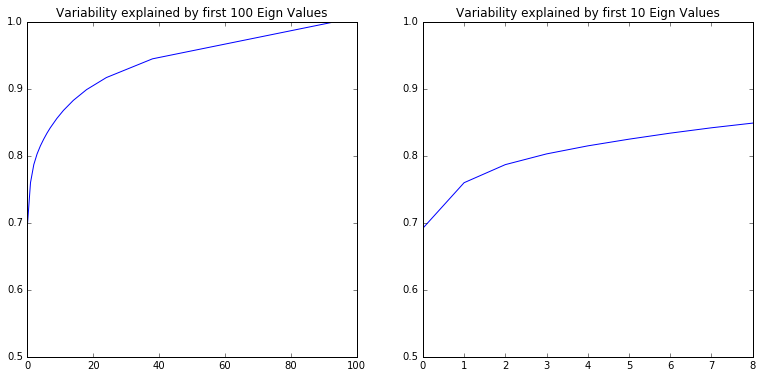

In [21]:
fig = plt.figure(1, figsize=(13,6))
plt.subplot(1,2,1)
plt.plot([var_explained(eig_val_a,x) for x in list(range(1,100))])
plt.title('Variability explained by first 100 Eign Values')
plt.ylim(ymax = 1, ymin = .5)
plt.subplot(1,2,2)
plt.plot([var_explained(eig_val_a,x) for x in list(range(1,10))])
plt.title('Variability explained by first 10 Eign Values')
plt.ylim(ymax = 1, ymin = .5)

<b>We can explain nearly 80% of the variation of Timbre Column A with just 4 components</b>

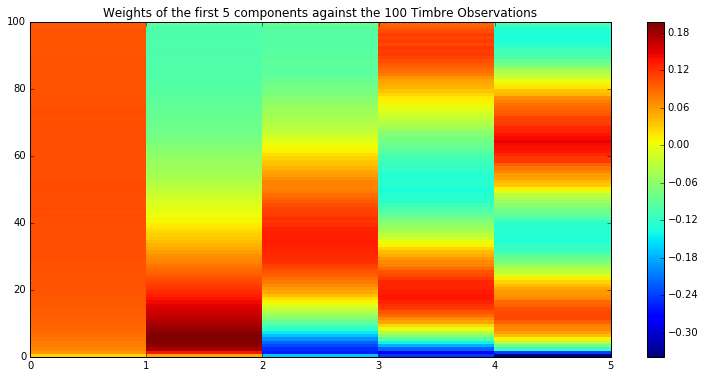

In [22]:
fig = plt.figure(1, figsize=(13,6))
vector=[]
for i in range(0,5):
     vector.append(Eig_a[i][1])
vector_df=pd.DataFrame(data=vector)
vector_df.transpose()
plt.pcolor(vector_df.transpose())
plt.colorbar()
plt.title('Weights of the first 5 components against the 100 Timbre Observations')

What does the above chart tell us?
* Component 1: Averages the first 100 Observations
* Component 2: Heavily weighted on first 20 Observations
* Component 3: Heavily weighted on the next 20
* Component 4: Heavily weightedon the next 20.


### Conclusion

It appears we can use PCA to reduce the first 100 Timbre Values into a very small number of underlying components.

Next Steps:  Can we do this for all 12 Timbre measurements?  Can we then Cluster on them?